
<img src="fga.png" width="1200" height="400">


<h1><center>Aula 4 - Algo Trading
</center></h1>

A presente atividade abordará um conjunto de 3 (três) estratégias didáticas de operações automáticas de compras, baseadas nos indicadores média móvel, MACD e as bandas de Bollinger. As estratégias são apresentadas no formato mais trivial possível, considerando o sentido pedagógico. Em contexto real, aspectos adicionais devem ser incorporados, como: i) um processo de otimização regular dos parâmetros, ii) a alocação de capital, iii) a natureza da ordem (mercado/limitada), iv) o período das médias, v) gestão do risco operacional e vi) custos das taxas, por exemplo.

<ul>
    <li> <b>Universidade de Brasília - UnB</b> </li>
    <li> <b>Campus UnB Gama</b> </li>
    <li> <b>Disciplina: Processamento Digital de Sinais Financeiros</b> </li>
    <a href="https://www.linkedin.com/in/marcelino-andrade-b164b369/">
    <li> <b>Prof. Marcelino Monteiro de Andrade Dr.</b> </li>
</ul>



<div id="Tópicos">
    <h2>Tópicos</h2>
</div>


<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol> 
        <li><a href="#Tópico 0">Funções Básicas de Referência</a></li>
        <li><a href="#Tópico 1">Aquisição de Sinais de Preço Bovespa</a></li>
        <li><a href="#Tópico 2">Estratégia Seguidor de Tendência Crossover</a></li>
        <li><a href="#Tópico 3">Estratégia Seguidor de Tendência MACD</a></li>
        <li><a href="#Tópico 4">Estratégia Reversão a Média Bandas de Bollinger</a></li>
</ol>
</div>




<p><b>Algumas Bibliotecas Python:</b></p>
<ul>
    <li> numpy (as np) </li>
    <li> matplotlib.pyplot (as plt) </li>
    <li> pandas </li>
    <li> seaborn (as sns) </li>
        <li> mpl_finance (as candlestick_ohlc) </li>
            <li> datetime </li>
                <li> pandas_datareader.data (as pdr)</li>
    <li> pickle</li>
     <li> datetime (as dt)</li>
      <li> signal (from scipy)</li>
</ul>


In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import investpy
import matplotlib.dates as mdates
from scipy import signal

import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

<div id="Tópico 0">
    <div class="alert alert-block alert-info" style="margin-top: 10px">
        <h><a href="#Tópicos"><h2>1) Funções Básicas de Referência</h2></a></h>   
</div> </div>

In [2]:
def ema(data, period=0, column='Close'):
    data['ema' + str(period)] = data[column].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()    
    return data

def macd(data, period_long=26, period_short=12, period_signal=9, column='Close'):
    remove_cols = []
    if not 'ema' + str(period_long) in data.columns:
        data = ema(data, period_long)
        remove_cols.append('ema' + str(period_long))

    if not 'ema' + str(period_short) in data.columns:
        data = ema(data, period_short)
        remove_cols.append('ema' + str(period_short))

    data['macd_val'] = data['ema' + str(period_short)] - data['ema' + str(period_long)]
    data['macd_signal_line'] = data['macd_val'].ewm(ignore_na=False, min_periods=0, com=period_signal, adjust=True).mean()

    data = data.drop(remove_cols, axis=1)
        
    return data

def bollinger_bands(data, trend_periods=20, deviation=2, close_col='Close'):

    data['bol_bands_middle'] = data[close_col].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    for index, row in data.iterrows():

        s = data[close_col].iloc[index - trend_periods: index]
        sums = 0
        middle_band = data.at[index, 'bol_bands_middle']
        for e in s:
            sums += np.square(e - middle_band)

        std = np.sqrt(sums / trend_periods)
   #     d = 2
        upper_band = middle_band + (deviation * std)
        lower_band = middle_band - (deviation * std)

        data.set_value(index, 'bol_bands_upper', upper_band)
        data.set_value(index, 'bol_bands_lower', lower_band)

    return data

def IFR(stock, period=14):
    delta = stock['Close'].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u = u.ewm(span=period,min_periods=0,adjust=False).mean() #first value is sum of avg gains
    d = d.ewm(span=period,min_periods=0,adjust=False).mean() #first value is sum of avg losses
    stock['IFR']=1 - 1 / (1 + u/d)
    return stock['IFR']

def sumper(per):
    persum=100*(np.exp(np.log1p(per/100).cumsum())-1)
    return persum

def result(values):
    x=list(values)
    lr=np.mean(x)/np.std(x)
    gains=[x for x in values if x > 0]
    losses=[x for x in values if x < 0]
    payoff=100*sumper(np.array(values))[-1]/len(x)
    return len(x),lr, payoff, len(gains)/len(losses), 100*len(gains)/len(x), 100*sumper(np.array(values))[-1]

<div id="Tópico 1">
    <div class="alert alert-block alert-info" style="margin-top: 0px">
        <h><a href="#Tópicos"><h2>2) Aquisição de Sinais de Preço Bovespa</h2></a></h>   
</div> </div> 

<p>Conjunto de procedimentos baseada na biblioteca <b>pandas_datareader.data</b> e <b>Yahoo Finance</b> para aquisição de preços e volumes de ativos finaceiros operados nas principais bolsas de valores mundiais</p>


In [3]:

stocks=['IRBR3','RAIL3','WEGE3','RENT3','BIDI4','TRIS3','CAML3']

out = None

for stk in tqdm(stocks):

    df = investpy.get_stock_historical_data(stock=stk,
                                            country='Brazil',
                                            from_date='01/01/2015',
                                            to_date='29/09/2020')

    if out is None:
        out=df["Close"]
    else:
        out=pd.concat([out,df["Close"]],axis=1)
out.columns=stocks
out.tail()

100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


,IRBR3,RAIL3,WEGE3,RENT3,BIDI4,TRIS3,CAML3
Date,,,,,,,
2020-09-22,6.30,20.79,62.50,58.97,17.57,11.05,13.11
2020-09-23,7.08,20.70,64.49,57.99,18.14,11.28,13.06
2020-09-24,7.17,20.84,64.25,59.00,17.83,11.00,13.07
2020-09-27,7.23,19.89,62.89,56.65,18.23,10.71,12.47
2020-09-28,7.31,19.14,64.94,56.79,18.11,10.55,12.45


<div id="Tópico 2">
    <div class="alert alert-block alert-info" style="margin-top: 0px">
        <h><a href="#Tópicos"><h2>3) Estratégia Seguidor de Tendência Crossover</h2></a></h>   
</div> </div>

<p>O Crossover corresponde a uma das mais simples estratégias de Trade automático, podendo ser baseadas no cruzamento do preço com uma média, no cruzamento de duas ou mais médias móveis. A seguir será desenvolvido uma solução, somente comprada, e baseada no cruzamento de duas médias. Assim, considerado uma média rápida $FMA$ e uma lenta $SMA$, o sinal de compra deve ocorrer quando</p>&emsp;
    
<ul>
    
  <li>$FMA[n-1] < SMA[n-1]$ e $FMA[n] > SMA[n]$ </li>

<p>E o sinal de venda<p>

  <li> $FMA[n-1] > SMA[n-1]$ e $FMA[n] < SMA[n]$ </li>

</ul>
<p>Ou ainda, a compra pode ocorrer quando a $FMA[n]$ apresentar um distância $k\sigma[n]$ acima da $SMA[n]$, após o cruzamento. E a venda em situação 
análoga e antagônica.</p>

<p>O valor de $k\sigma[n]$ e dos periodos das médias $FMA$ e $SMA$ podem ser extraídos de processo de otimização, considerando janelas temporais significativas e aplicados
em periodos out-of-sample (OOS) e in-sample (IS). </p>

  

/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


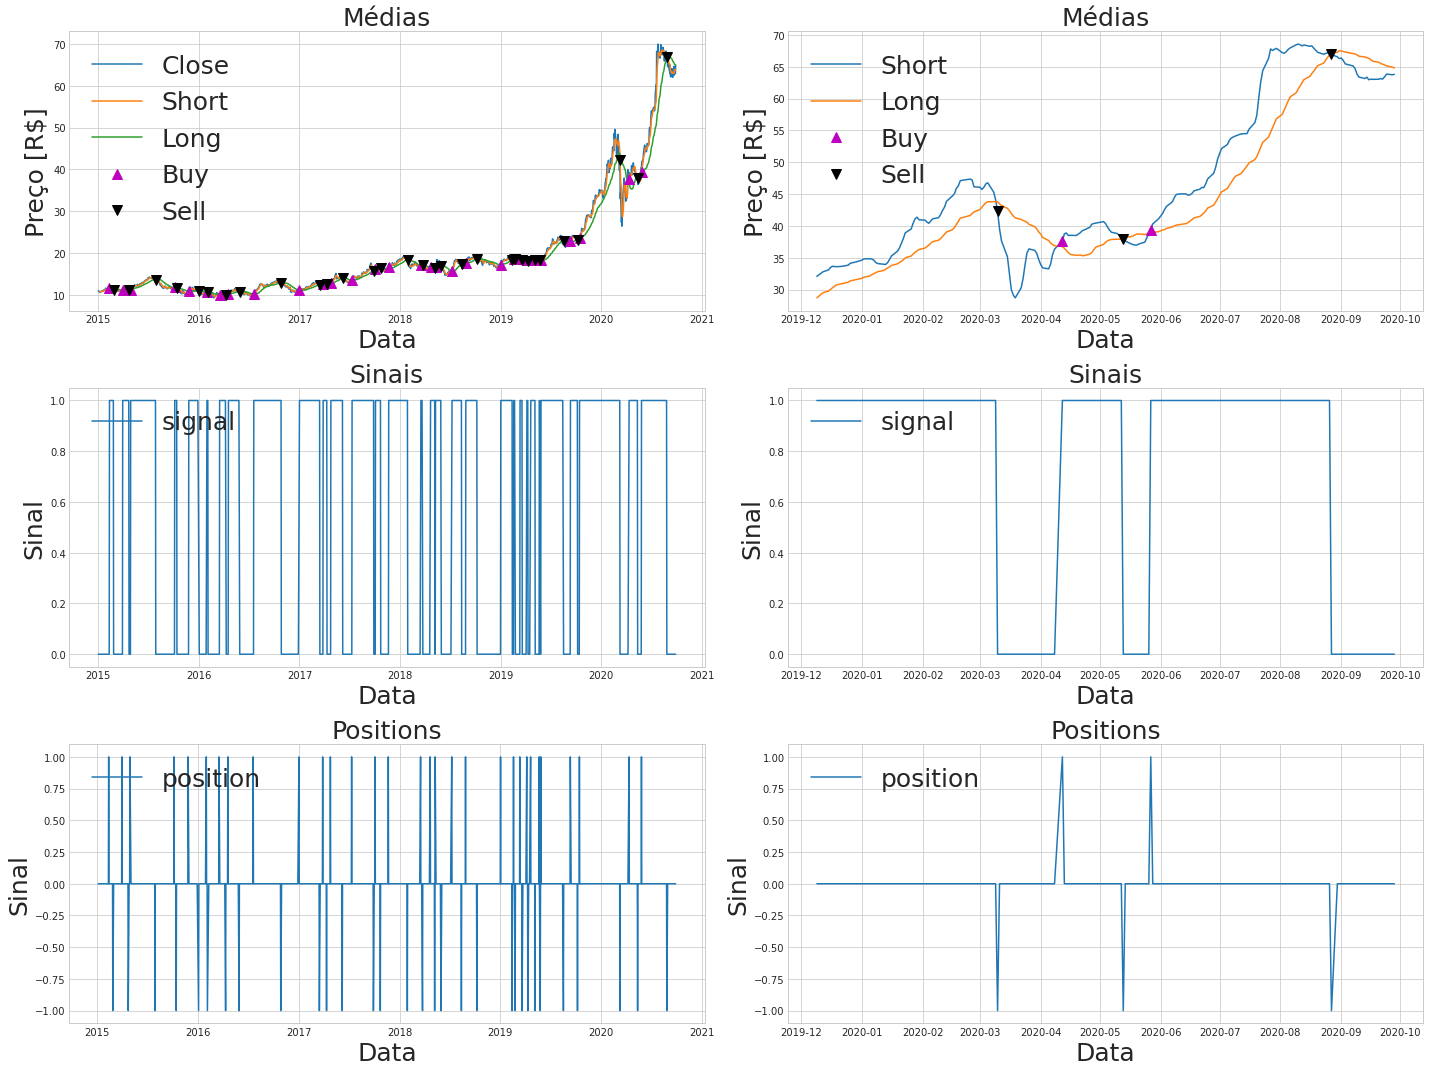

In [4]:
trades = pd.DataFrame(index=out.index)
trades['Close']=out['WEGE3'].values

short=5
long=30

trades['short'] = trades['Close'].rolling(window=short).mean()
trades['long'] = trades['Close'].rolling(window=long).mean()

# Sinal de Entrada
trades['signal']=0
trades['signal'][short:] = np.where(trades['short'][short:] > trades['long'][short:], 1.0, 0.0)   

# Posição dos trades
trades['positions'] = trades['signal'].diff()

fig = plt.subplots(figsize=(20,15))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(321)
ax1.plot(trades['Close'], label='Close')
ax1.plot(trades['short'], label='Short')
ax1.plot(trades['long'],label='Long')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.short[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.short[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Médias",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)

ax2 = plt.subplot(322)
#ax2.plot(trades['Close'][-200:], label='Close')
ax2.plot(trades['short'][-200:], label='Short')
ax2.plot(trades['long'][-200:],label='Long')
ax2.set_ylabel("Preço [R$]",fontsize=25)
ax2.set_xlabel("Data",fontsize=25)
ax2.set_title("Médias",fontsize=25)
ax2.plot(trades[-200:].loc[trades[-200:].positions == 1.0].index, 
         trades[-200:].short[trades[-200:].positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax2.plot(trades[-200:].loc[trades[-200:].positions == -1.0].index, 
         trades[-200:].short[trades[-200:].positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 
ax2.legend(loc='upper left',fontsize=25)

ax3 = plt.subplot(323)
ax3.plot(trades['signal'], label='signal')
ax3.set_ylabel("Sinal",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Sinais",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)

ax4 = plt.subplot(324)
ax4.plot(trades['signal'][-200:], label='signal')
ax4.set_ylabel("Sinal",fontsize=25)
ax4.set_xlabel("Data",fontsize=25)
ax4.set_title("Sinais",fontsize=25)
ax4.legend(loc='upper left',fontsize=25)

ax5 = plt.subplot(325)
ax5.plot(trades['positions'], label='position')
ax5.set_ylabel("Sinal",fontsize=25)
ax5.set_xlabel("Data",fontsize=25)
ax5.set_title("Positions",fontsize=25)
ax5.legend(loc='upper left',fontsize=25)

ax6 = plt.subplot(326)
ax6.plot(trades['positions'][-200:], label='position')
ax6.set_ylabel("Sinal",fontsize=25)
ax6.set_xlabel("Data",fontsize=25)
ax6.set_title("Positions",fontsize=25)
ax6.legend(loc='upper left',fontsize=25)
plt.tight_layout() 

<div>
    <div class="alert alert-block alert-info" style="margin-top: 5px">
        <h>3.1) Retornos da Estratégia Seguidor de Tendência Crossover</h>
</div> </div>


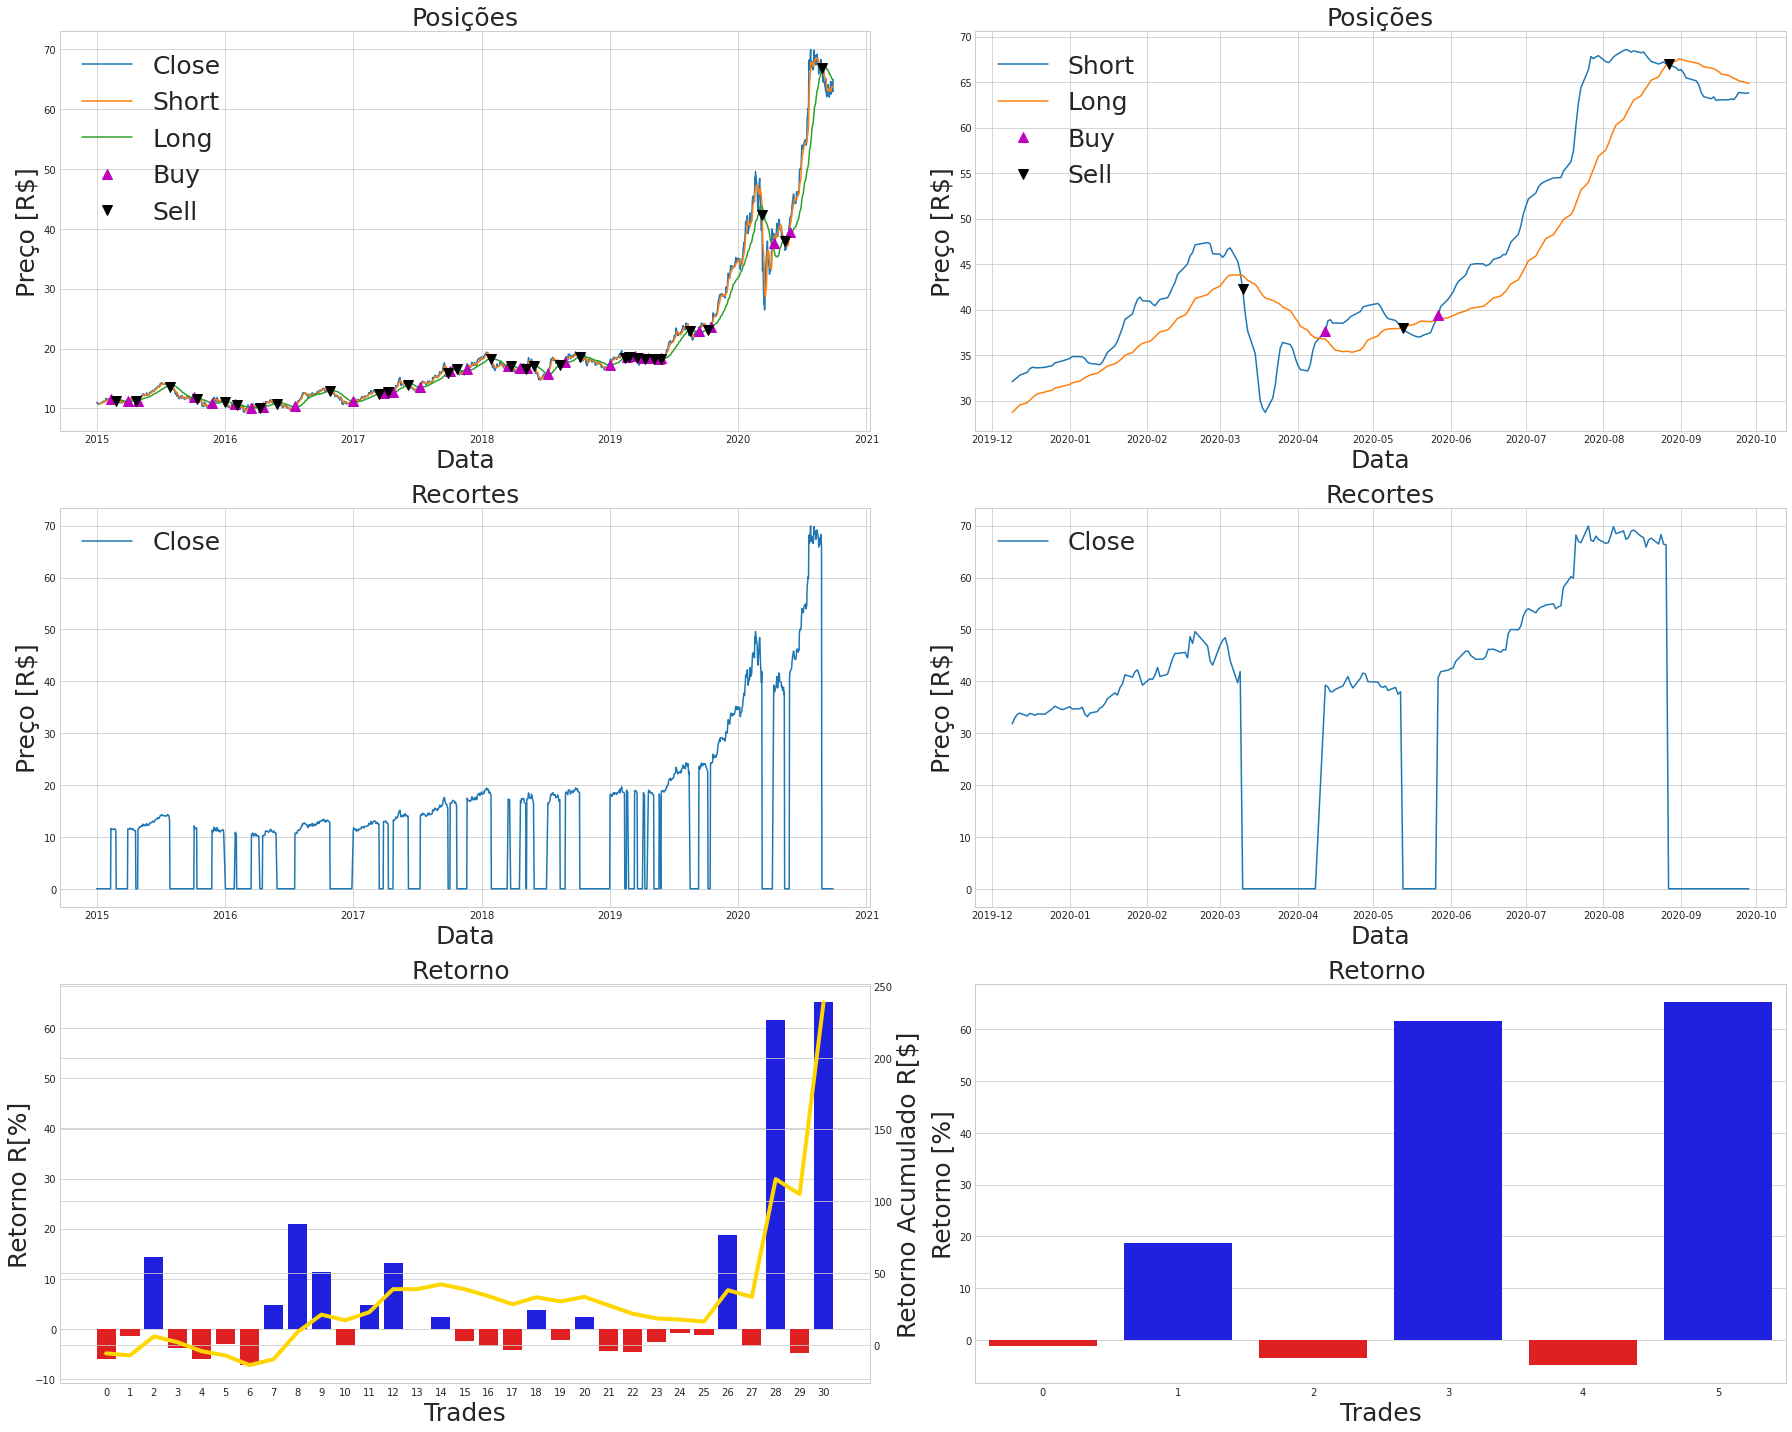

In [5]:
trades['Close_recorte']=trades['Close']*trades['signal']
%matplotlib inline   
fig = plt.subplots(figsize=(25,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(321)
ax1.plot(trades['Close'], label='Close')
ax1.plot(trades['short'], label='Short')
ax1.plot(trades['long'],label='Long')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.short[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.short[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Posições",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)

ax2 = plt.subplot(322)
#ax2.plot(trades['Close'][-200:], label='Close')
ax2.plot(trades['short'][-200:], label='Short')
ax2.plot(trades['long'][-200:],label='Long')
ax2.set_ylabel("Preço [R$]",fontsize=25)
ax2.set_xlabel("Data",fontsize=25)
ax2.set_title("Posições",fontsize=25)
ax2.plot(trades[-200:].loc[trades[-200:].positions == 1.0].index, 
         trades[-200:].short[trades[-200:].positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax2.plot(trades[-200:].loc[trades[-200:].positions == -1.0].index, 
         trades[-200:].short[trades[-200:].positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 
ax2.legend(loc='upper left',fontsize=25)

ax3 = plt.subplot(323)
ax3.plot(trades['Close_recorte'], label='Close')
ax3.set_ylabel("Preço [R$]",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Recortes",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)

ax4 = plt.subplot(324)
ax4.plot(trades['Close_recorte'][-200:], label='Close')
ax4.set_ylabel("Preço [R$]",fontsize=25)
ax4.set_xlabel("Data",fontsize=25)
ax4.set_title("Recortes",fontsize=25)
ax4.legend(loc='upper left',fontsize=25)

ax5 = plt.subplot(325)
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append(100*(values_2-values_1)/values_1)

values = np.array(buy_trade)
values1=buy_trade

idx = np.array(list(range(len(buy_trade)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 

plt.ylabel('Retorno R[%]',fontsize=25)
plt.xlabel('Trades',fontsize=25)

ax52 = ax5.twinx()

ax52.plot(sumper(values),'gold',linewidth=4)

plt.ylabel('Retorno Acumulado R[$]',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retorno ',fontsize=25)


ax6 = plt.subplot(326)
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append(100*(values_2-values_1)/values_1)
values = np.array(buy_trade[-6:])   
idx = np.array(list(range(len(values)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 


plt.ylabel('Retorno [%]',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retorno ',fontsize=25)
plt.tight_layout() 


<div id="Tópico 3">
    <div class="alert alert-block alert-info" style="margin-top: 1px">
        <h><a href="#Tópicos"><h2>4) Estratégia Seguidor de Tendência MACD</h2></a></h>   
</div> </div>

<p>Desenvolvido por <b>Gerald Appel</b> no final dos anos 70, o MACD (Moving Average Convergence / Divergence Oscillator) transforma dois seguidores de tendência, médias móveis, em um oscilador de momento. A seguir será apresentada uma estratégia, somente comprada, e baseada no cruzamento dos sinais do $MACD$.</p>

<p>O <b>Sinal de Compra</b><p>

  <li>$MACD[n]>Sinal[n]$ e $MACD[n-1]>Sinal[n-1]$</li>

<p>O <b>Sinal de Venda</b><p>

  <li>$MACD[n] < Sinal[n]$ e $MACD[n-1] < Sinal[n-1]$</li>

<p>Ou ainda, para ficar fiel ao setup apresentado por <b> Gerald Appel</b> a compra pode ocorrer quando o $MACD[n]$ e o $Sinal[n]$ apresentarem valores negativos.</p>


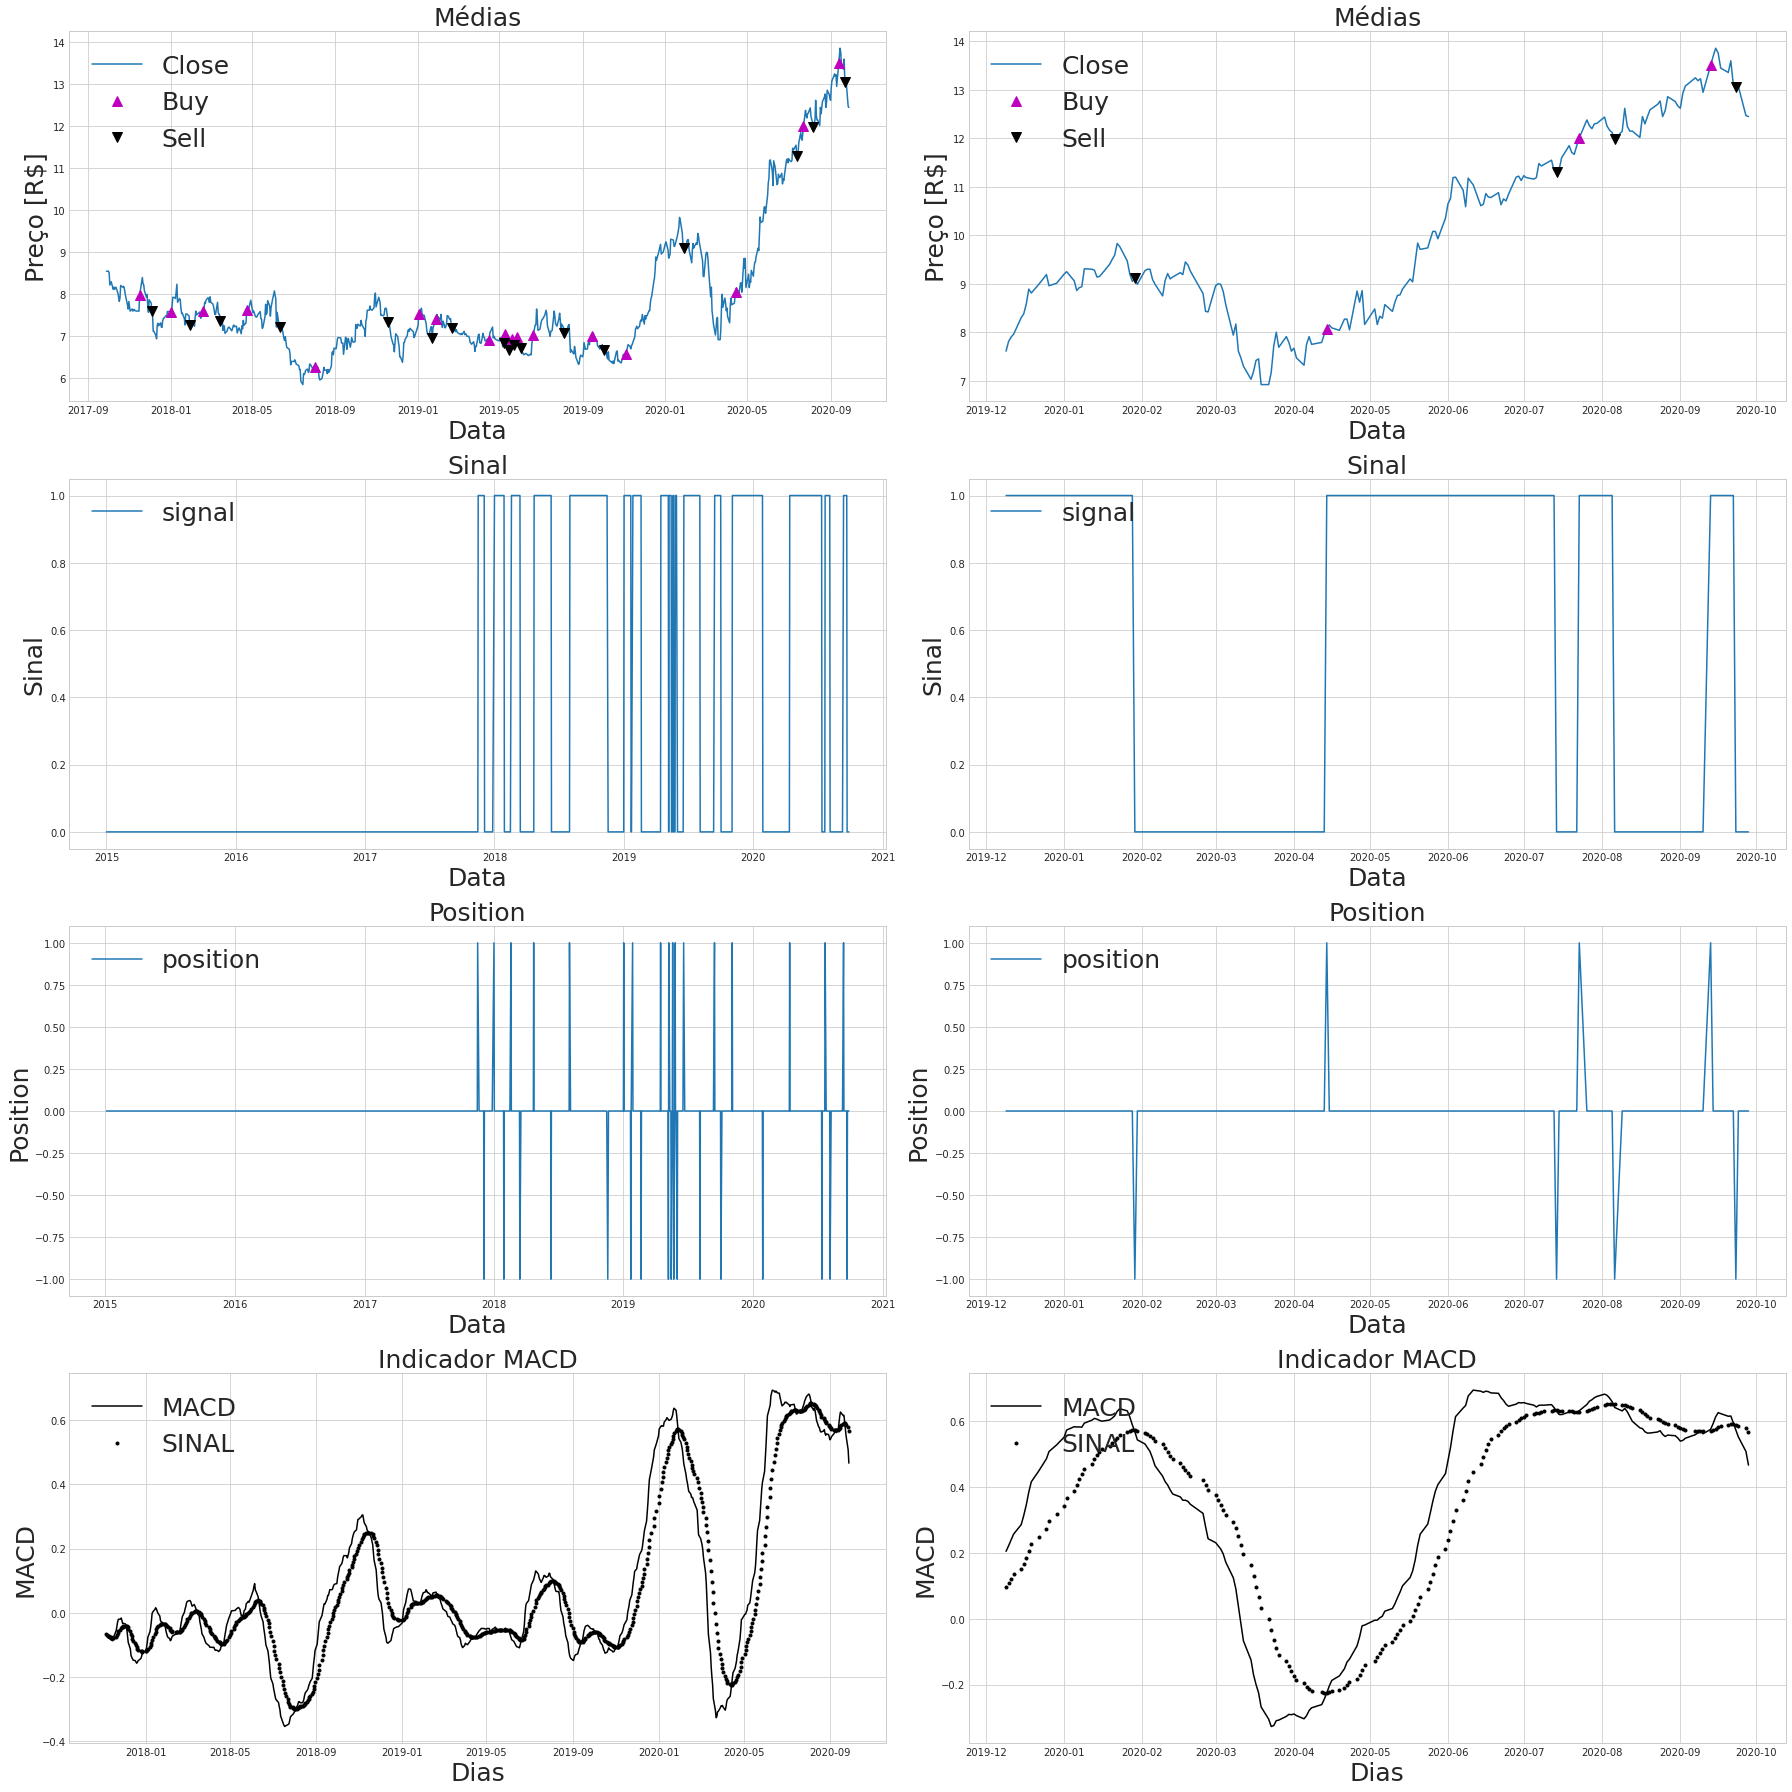

In [6]:
trades = pd.DataFrame(index=out.index)
trades['Close']=out['CAML3'].values
macd(trades)
# Sinal de Entrada
trades['signal']=0
trades['signal'] = np.where(trades['macd_val'] > trades['macd_signal_line'], 1.0, 0.0)   

# Posição dos trades
trades['positions'] = trades['signal'].diff()

fig = plt.subplots(figsize=(25,25))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(421)
ax1.plot(trades['Close'], label='Close')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.Close[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.Close[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Médias",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)

ax2 = plt.subplot(422)
ax2.plot(trades['Close'][-200:], label='Close')

ax2.set_ylabel("Preço [R$]",fontsize=25)
ax2.set_xlabel("Data",fontsize=25)
ax2.set_title("Médias",fontsize=25)

ax2.plot(trades[-200:].loc[trades[-200:].positions == 1.0].index, 
         trades[-200:].Close[trades[-200:].positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax2.plot(trades[-200:].loc[trades[-200:].positions == -1.0].index, 
         trades[-200:].Close[trades[-200:].positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax2.legend(loc='upper left',fontsize=25)

ax3 = plt.subplot(423)
ax3.plot(trades['signal'], label='signal')
ax3.set_ylabel("Sinal",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Sinal",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)

ax4 = plt.subplot(424)
ax4.plot(trades['signal'][-200:], label='signal')
ax4.set_ylabel("Sinal",fontsize=25)
ax4.set_xlabel("Data",fontsize=25)
ax4.set_title("Sinal",fontsize=25)
ax4.legend(loc='upper left',fontsize=25)

ax5 = plt.subplot(425)
ax5.plot(trades['positions'], label='position')
ax5.set_ylabel("Position",fontsize=25)
ax5.set_xlabel("Data",fontsize=25)
ax5.set_title("Position",fontsize=25)
ax5.legend(loc='upper left',fontsize=25)

ax6 = plt.subplot(426)
ax6.plot(trades['positions'][-200:], label='position')
ax6.set_ylabel("Position",fontsize=25)
ax6.set_xlabel("Data",fontsize=25)
ax6.set_title("Position",fontsize=25)
ax6.legend(loc='upper left',fontsize=25)

ax7 = plt.subplot(427)
ax7.plot(trades['macd_val'], 'k', label = 'MACD')
ax7.plot(trades['macd_signal_line'], 'k.', label = 'SINAL')
ax7.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax7.legend(loc='upper left',fontsize=25)

ax7.set_xlabel("Dias",fontsize=25)
ax7.set_ylabel('MACD',fontsize=25)
ax7.set_title('Indicador MACD',fontsize=25) 

ax8 = plt.subplot(428)
ax8.plot(trades['macd_val'][-200:], 'k', label = 'MACD')
ax8.plot(trades['macd_signal_line'][-200:], 'k.', label = 'SINAL')
ax8.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax8.legend(loc='upper left',fontsize=25)

ax8.set_xlabel("Dias",fontsize=25)
ax8.set_ylabel('MACD',fontsize=25)
ax8.set_title('Indicador MACD',fontsize=25) 
plt.tight_layout() 


<div>
    <div class="alert alert-block alert-info" style="margin-top: 5px">
        <h>4.1) Retornos Estratégia Seguidor de Tendência MACD¶</h>
</div> </div>

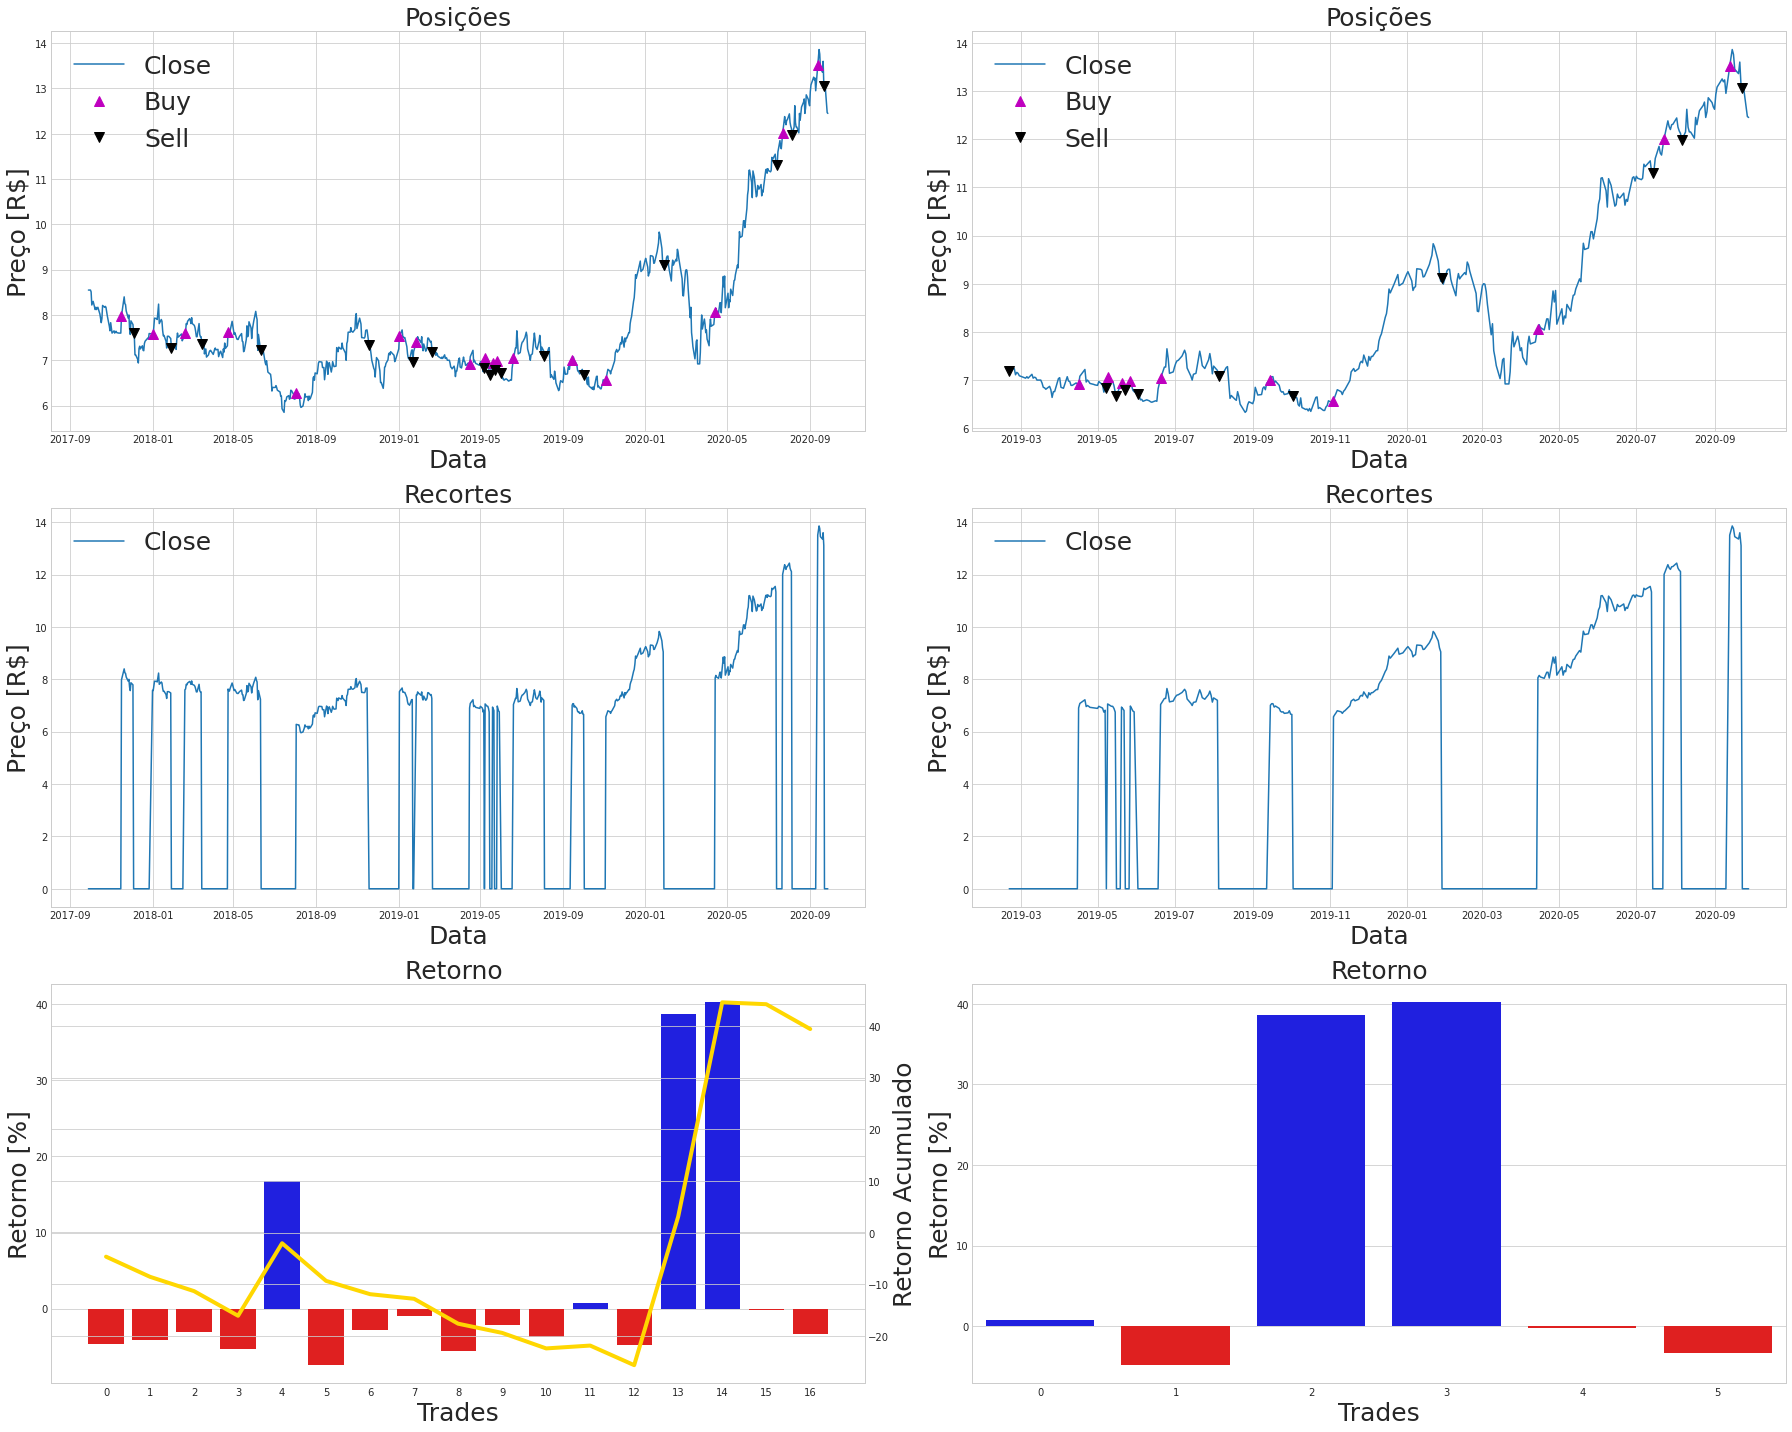

In [7]:
trades['Close_recorte']=trades['Close']*trades['signal']

fig = plt.subplots(figsize=(25,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(321)
ax1.plot(trades['Close'], label='Close')
#ax1.plot(trades['short'], label='Short')
#ax1.plot(trades['long'],label='Long')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.Close[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.Close[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Posições",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)

ax2 = plt.subplot(322)
ax2.plot(trades['Close'][-400:], label='Close')
#ax2.plot(trades['short'][-200:], label='Short')
#ax2.plot(trades['long'][-200:],label='Long')
ax2.set_ylabel("Preço [R$]",fontsize=25)
ax2.set_xlabel("Data",fontsize=25)
ax2.set_title("Posições",fontsize=25)
ax2.plot(trades[-400:].loc[trades[-400:].positions == 1.0].index, 
         trades[-400:].Close[trades[-400:].positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax2.plot(trades[-400:].loc[trades[-400:].positions == -1.0].index, 
         trades[-400:].Close[trades[-400:].positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 
ax2.legend(loc='upper left',fontsize=25)

ax3 = plt.subplot(323)
ax3.plot(trades['Close_recorte'], label='Close')
ax3.set_ylabel("Preço [R$]",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Recortes",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)

ax4 = plt.subplot(324)
ax4.plot(trades['Close_recorte'][-400:], label='Close')
ax4.set_ylabel("Preço [R$]",fontsize=25)
ax4.set_xlabel("Data",fontsize=25)
ax4.set_title("Recortes",fontsize=25)
ax4.legend(loc='upper left',fontsize=25)

ax5 = plt.subplot(325)
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append(100*(values_2-values_1)/values_1)
values = np.array(buy_trade)   
values2=buy_trade

idx = np.array(list(range(len(buy_trade)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 


ax5.set_ylabel('Retorno [%]',fontsize=25)
ax5.set_xlabel('Trades',fontsize=25)
#ax5.set_title('Retorno',fontsize=25)
ax52 = ax5.twinx()
ax52.plot(sumper(values),'gold',linewidth=4)

plt.ylabel('Retorno Acumulado',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retorno ',fontsize=25)

ax6 = plt.subplot(326)
pos_buy=trades['positions']==1
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append(100*(values_2-values_1)/values_1)
    
values = np.array(buy_trade[-6:])   
idx = np.array(list(range(len(values)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 


plt.ylabel('Retorno [%]',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retorno',fontsize=25)
plt.tight_layout() 


<div id="Tópico 4">
    <div class="alert alert-block alert-info" style="margin-top: 0px">
        <h><a href="#Tópicos"><h2>5) Estratégia Reversão a Média Bandas de Bollinger</h2></a></h>   
</div> </div>

<p>A estratégia em bandas de bollinger apresentada obedece a conjuntura de retorno à média central da banda. A seguir será desenvolvido uma estratégia, somente comprada, e baseada nas bandas de Bollinger. Assim, considerado banda inferior $Bandlower$, a banda média $Bandmiddle$ e o preço de fechamento $Close$,</p>

<p>o <b>sinal de compra</b> deve ocorrer quando</p>&emsp;

<li>$Bandlower[n-1] < Close[n-1]$ e $Bandlower[n] > Close[n]$</li>&emsp;

<p>e o <b>sinal de venda</b><p>&emsp;

<li>$Bandmiddle[n-1] > Close[n-1]$ e $Bandmiddle[n] < Close[n]$</li>

 

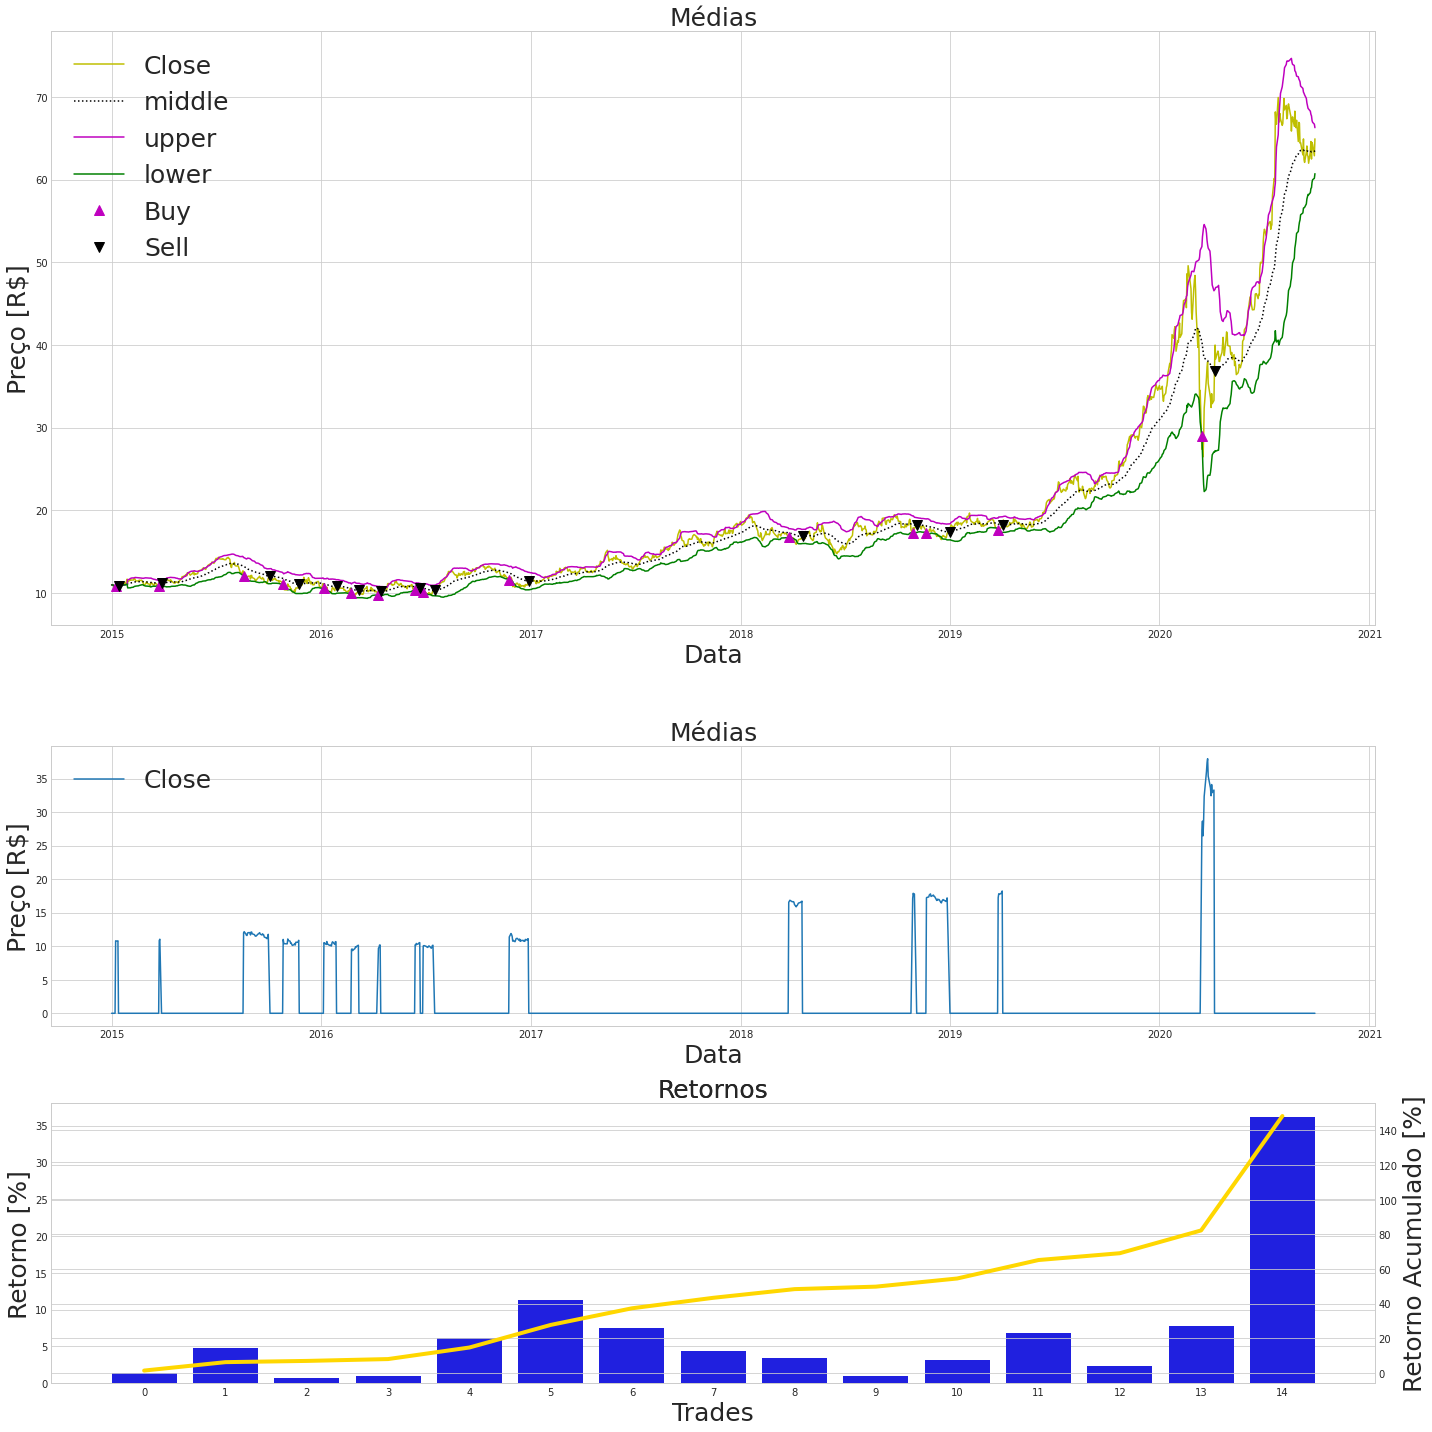

In [8]:
trades = pd.DataFrame(index=out.index)
trades['Close']=out['WEGE3'].values

trades.reset_index(inplace=True)
bollinger_bands(trades)

trades=trades.set_index('Date')
# Sinal de Entrada
trades['signal']=0
signal=np.zeros(len(trades['signal']))
buy=0
for day in range(1,len(trades)):
    cond1_buy=trades['Close'].iloc[day-1] > trades['bol_bands_lower'].iloc[day-1]
    cond2_buy=trades['Close'].iloc[day] < trades['bol_bands_lower'].iloc[day]  
    cond1_sell=trades['Close'].iloc[day-1] < trades['bol_bands_middle'].iloc[day-1]
    cond2_sell=trades['Close'].iloc[day] > trades['bol_bands_middle'].iloc[day]   

    if cond1_buy & cond2_buy:
        buy = 1
    if (buy == True) & cond1_sell & cond2_sell:
        buy = 0
    signal[day]=buy
trades['signal']=signal
#condition2=trades['Close'] < trades['bol_bands_lower']

#trades['signal'] = np.where(, 1.0, 0.0)   

#trades
# Posição dos trades
trades['positions'] = trades['signal'].diff()

fig = plt.subplots(figsize=(20,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(211)
ax1.plot( trades.Close, 'y', label = 'Close')
ax1.plot( trades.bol_bands_middle, 'k:', label = 'middle')
ax1.plot( trades.bol_bands_upper, 'm', label = 'upper')
ax1.plot( trades.bol_bands_lower, 'g', label = 'lower')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.bol_bands_lower[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.bol_bands_middle[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Médias",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)



trades['Close_recorte']=trades['Close']*trades['signal']

#trades['Close_recorte'][trades['Close_recorte']==0]=16

ax3 = plt.subplot(413)
ax3.plot(trades['Close_recorte'], label='Close')
ax3.set_ylabel("Preço [R$]",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Médias",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)



ax5 = plt.subplot(414)
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append(100*(values_2-values_1)/values_1)
values = np.array(buy_trade)   
values3=buy_trade
plt.ylabel('Retorno [%]',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retornos',fontsize=25)


idx = np.array(list(range(len(buy_trade)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 
ax52 = ax5.twinx()
ax52.plot(sumper(values),'gold',linewidth=4)

plt.ylabel('Retorno Acumulado [%]',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retornos',fontsize=25)

plt.tight_layout() 



<b>Fim da Atividade!!!</b> 
